# Standard Analysis Script

This script analyzes the standard data of any system:

- Temperature
- Pressure
- Density
- Potential Energy
- Kinetic Energy
- Total Energy
- Mindistance to periodic images
- Protein RMSD
- Protein RMSF

In [40]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import MDAnalysis as mda


traj = "../Sample_files/centered_step7_1.xtc"
top = "../Sample_files/step6.6_equilibration.gro"
energy = "../Sample_files/sample_energies.edr"

in_memory = True
memory_step = 1

## Temperature, pressure, density, volume, energies

In [10]:
try:
    os.mkdir("Analysis/Stats")
    print("Folder Analysis/Stats created")
except OSError as error:
    print("Can't create folder: folder Analysis/Stats already exists")


variables = ["temperature", "density", "pressure", "volume", "potential", "kinetic-en", "total-energy"]

for variable in variables:
    os.system(f"echo {variable}|gmx energy -f {energy} -o Analysis/Stats/{variable}.xvg")

Can't create folder: folder Analysis/Stats already exists

Statistics over 1500001 steps [ 0.0000 through 30000.0000 ps ], 1 data sets
All statistics are over 15001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 302.486      0.021    3.38333  0.0460752  (K)

Statistics over 1500001 steps [ 0.0000 through 30000.0000 ps ], 1 data sets
All statistics are over 15001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1093.88      0.061    3.43314   0.246007  (kg/m^3)

Statistics over 1500001 steps [ 0.0000 through 30000.0000 ps ], 1 data sets
All statistics are over 15001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-----------------------------------------------------------------------------

                       :-) GROMACS - gmx energy, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx energy -f ../Sample_files/sample_energies.edr -o Analysis/Stats/temperature.xvg

Opened ../Sample_files/sample_energies.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  G96Angle         3  Improper-Dih.    4  LJ-(SR)       
  5  Coulomb-(SR)     6  Potential        7  Kinetic-En.      8  Total-Energy  
  9  Conserved-En.   10  Temperature     11  Pressure        12  Constr.-rmsd  
 13  Box-X           14  Box-Y           15  Box-Z           16  Volume        
 17  Density         18  pV              19  Enthalpy      

In [14]:
#Function to read .xvg files into a proper DataFrame to plot later, removing the header, first column is time, second is the variable
def read_xvg(file, x_name, y_name, skip_lines):
    data = {x_name: [], y_name:[]} #Empty dict to store the data
    temp_file = open(file, 'r')
    temp_lines = temp_file.readlines()[skip_lines:] #This removes header lines

    for line in temp_lines: #Iterate, split data by space, get first number (time) and second (variable) and store in dictionary
        values = line.split()
        data[x_name].append(float(values[0])); data[y_name].append(float(values[1]))

    df = pd.DataFrame(data)
    return df

#Function to get average of variable in a window-sliding fashion
def get_avg(df, column_name, window):
    df['Avg'] = df[column_name]
    for i in range(len(df[column_name])):
        if i < window:
            df['Avg'][i] = None #Ignore rows until window size
        else:
            df['Avg'][i] = np.mean(df[column_name][(i-window):i]) #Add mean column
    return df

In [30]:
print(read_xvg(f"./Analysis/Stats/temperature.xvg", 'Time', k, 24))
print(get_avg(read_xvg(f"./Analysis/Stats/temperature.xvg", 'Time', "temperature", 24), "temperature", 10))

        Time  kinetic-en
0        0.0  301.290619
1      100.0  299.208557
2      200.0  301.583496
3      300.0  297.814667
4      400.0  302.742401
..       ...         ...
296  29600.0  306.907715
297  29700.0  301.171570
298  29800.0  304.998749
299  29900.0  309.309265
300  30000.0  299.873840

[301 rows x 2 columns]
        Time  temperature         Avg
0        0.0   301.290619         NaN
1      100.0   299.208557         NaN
2      200.0   301.583496         NaN
3      300.0   297.814667         NaN
4      400.0   302.742401         NaN
..       ...          ...         ...
296  29600.0   306.907715  301.166540
297  29700.0   301.171570  300.875476
298  29800.0   304.998749  301.212347
299  29900.0   309.309265  301.981036
300  30000.0   299.873840  302.909314

[301 rows x 3 columns]


In [38]:
#Terms to plot for quality analysis
dict_terms = {'temperature': 'Temperature (K)', 'pressure': 'Pressure (bars)', 
              'volume': 'Volume ($nm3$)', 'density': 'Density (kg/$nm^3$)', 
              'potential': 'Energy (kJ/mol)', 'kinetic-en': 'Energy (kJ/mol)'}

for k,v in dict_terms.items():
    term_df = read_xvg(f"./Analysis/Stats/{k}.xvg", 'Time', k, 24) #Read file .xvg into a dataframe

    term_df = get_avg(term_df, k, 25) #Get avgs
    
    term_df["Time"] = term_df["Time"]/1000

    #Plot
    plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
    sns_term = sns.lineplot(x='Time', y=k, data=term_df) #Plot term over time
    sns_temp = sns.lineplot(x='Time', y='Avg', data=term_df) #Plot avg term over time
    sns_temp.set_xlabel('Time (ns)')
    y_ax_label = v #get y axis name based on term being plotted
    sns_temp.set_ylabel(y_ax_label) #Change y axis label
    fig = sns_temp.get_figure()  # Get figure
    output_name = f"./Analysis/Stats/{k}.png"
    fig.savefig(output_name,dpi=300, bbox_inches='tight')  # Save graph in folder
    plt.clf()  # Erase plot to avoid stacking one on each other

/tmp/ipykernel_193421/1517571656.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
/tmp/ipykernel_193421/1517571656.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
/tmp/ipykernel_193421/1517571656.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are d

<Figure size 432x288 with 0 Axes>

## Protein RMSD

In [41]:
#Load trajectory as MDA universe object
u = mda.Universe(top, traj, in_memory=in_memory, in_memory_step=memory_step)

#Store times from each frame of the trajectory
times = [ts.time for ts in u.trajectory]

print("Loaded trajectory: {}".format(u))
print("Number of frames: {}".format(len(u.trajectory)))

/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: T
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(

Loaded trajectory: <Universe with 32181 atoms>
Number of frames: 10001


In [79]:
from MDAnalysis.analysis import rms, align
R = rms.RMSD(u,  # coordinates to align
         u,  # reference coordinates
         select="protein and name BB",
         ref_frame=0) #frame index of the reference
R.run()


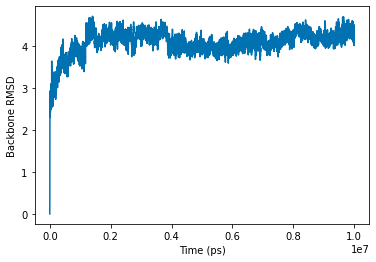

In [84]:
df = pd.DataFrame(R.results.rmsd, columns=["Frame", "Time (ps)", "Backbone RMSD"])

ax = sns.lineplot(x="Time (ps)",  y="Backbone RMSD", data=df)
fig = ax.get_figure()  # Get figure
fig.savefig("./Analysis/Stats/RMSD.svg")

In [86]:
average = align.AverageStructure(u,u, select="protein and name BB", ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref, select="protein and name BB", in_memoery=True).run()

BB = u.select_atoms("protein and name BB")
R2 = rms.RMSF(BB).run()

/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/apmlab/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


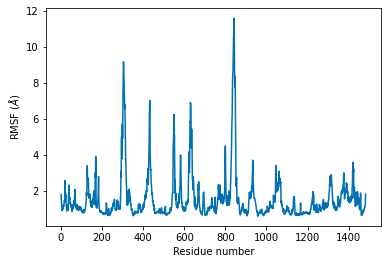

In [87]:
sns.lineplot(BB.resids, R2.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
fig = ax.get_figure()  # Get figure
fig.savefig("./Analysis/Stats/RMSF.svg")
#plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='X')
#plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='X')
#plt.legend();

In [88]:
from MDAnalysis.tests.datafiles import MULTIPDB_HOLE

u = mda.Universe(MULTIPDB_HOLE)

ha = hole2.HoleAnalysis(u, select='protein',
                        cpoint='center_of_geometry',
                        executable='~/hole2/exe/hole')
ha.run(random_seed=31415)

*** ERROR ***
In order to run the MDAnalysis test cases you must install the
MDAnalysisTestData package (which has been separated from the 
library code itself since release 0.7.4). Go to 

     http://pypi.python.org/pypi/MDAnalysisTests

and download and install the `MDAnalysisTests-x.y.z.tar.gz'
that matches your MDAnalysis release.


ImportError: MDAnalysisTests package not installed.